## 1. Introduction

The dataset available at [plants dataset](https://archive.ics.uci.edu/dataset/180/plants) contains information on plant species and genera, along with their occurrences in various states of the USA and Canada. This dataset, sourced from the USDA plants database, is ideal for applying clustering techniques to analyze plant distribution patterns. By leveraging PySpark's powerful capabilities, we can efficiently load, process, and cluster the data. Through clustering, I aim to identify groups of plant species with similar geographic distributions. This exploration can offer valuable insights into ecological associations and geographical factors influencing plant occurrences.

## 2. Connection to Spark Cluster

To connect to the Spark cluster, we create a SparkSession object with the following params:

+ **appName:** application name displayed at the [Spark Master Web UI](http://localhost:8080/);
+ **master:** Spark Master URL, same used by Spark Workers;
+ **spark.executor.memory:** must be less than or equals to docker compose SPARK_WORKER_MEMORY config.

In [1]:
# %%capture
!pip install matplotlib scikit-learn seaborn pyspark-dbscan pyspark[sql]


[notice] A new release of pip is available: 23.0 -> 23.1.2
[notice] To update, run: python3 -m pip install --upgrade pip


In [7]:
import warnings
warnings.filterwarnings("ignore")  # Ignore warnings coming from Arrow optimizations

import pyspark
import pyspark.pandas as ps
from pyspark.sql import SparkSession

spark = SparkSession.\
        builder.\
        appName("plants-notebook").\
        master("spark://spark-master:7077").\
        config("spark.executor.memory", "512m").\
        getOrCreate()

prev = spark.conf.get("spark.sql.execution.arrow.pyspark.enabled")  # Keep its default value.
ps.set_option("compute.default_index_type", "distributed")  # Use default index prevent overhead.

In [10]:
spark.conf.set("spark.sql.execution.arrow.pyspark.enabled", True)
%timeit ps.range(300000).to_pandas()

Py4JJavaError: An error occurred while calling o62.defaultParallelism.
: java.lang.IllegalStateException: Cannot call methods on a stopped SparkContext.
This stopped SparkContext was created at:

org.apache.spark.api.java.JavaSparkContext.<init>(JavaSparkContext.scala:58)
sun.reflect.NativeConstructorAccessorImpl.newInstance0(Native Method)
sun.reflect.NativeConstructorAccessorImpl.newInstance(NativeConstructorAccessorImpl.java:62)
sun.reflect.DelegatingConstructorAccessorImpl.newInstance(DelegatingConstructorAccessorImpl.java:45)
java.lang.reflect.Constructor.newInstance(Constructor.java:423)
py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:247)
py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
py4j.Gateway.invoke(Gateway.java:238)
py4j.commands.ConstructorCommand.invokeConstructor(ConstructorCommand.java:80)
py4j.commands.ConstructorCommand.execute(ConstructorCommand.java:69)
py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
py4j.ClientServerConnection.run(ClientServerConnection.java:106)
java.lang.Thread.run(Thread.java:750)

The currently active SparkContext was created at:

(No active SparkContext.)
         
	at org.apache.spark.SparkContext.assertNotStopped(SparkContext.scala:120)
	at org.apache.spark.SparkContext.defaultParallelism(SparkContext.scala:2559)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.lang.Thread.run(Thread.java:750)


In [ ]:
spark.conf.set("spark.sql.execution.arrow.pyspark.enabled", False)
%timeit ps.range(300000).to_pandas()

In [35]:
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.clustering import KMeans, GaussianMixture, BisectingKMeans
# from pyspark_dbscan import DBSCAN
from pyspark.ml.feature import VectorAssembler
import matplotlib.pyplot as plt

## 3. Load and Store Data
We will now load data from a local CSV and store it to Hadoop partitioned by column.
Afterward you can access Hadoop UI to explore the saved parquet files.
Access Hadoop UI on 'http://localhost:9870' (Utilities -> Browse the files system )

In [3]:
import pandas as pd
from pyspark.sql.types import *
from pyspark.sql import functions as F
import os
import time
epochNow = int(time.time())

In [4]:
with open('plants.data', 'r', encoding="ISO-8859-1") as f:
    lines = f.readlines()

In [7]:
plant2states = {}
for line in lines:
    split = line[:-1].split(',')
    plant2states[split[0]] = split[1:]
    
states = set()
for states_list in plant2states.values():
    for state in states_list:
        states.add(state)

data = {state: [] for state in ['plant'] + list(states)}
for plant, states_list in plant2states.items():
    data['plant'].append(plant)
    for state in states:
        data[state].append(1 if state in states_list else 0)

In [8]:
# Create DataFrame from dictionary
df = ps.DataFrame(data)

# Show DataFrame
df

,plant,ma,il,nu,nb,in,fraspm,mt,co,or,...,nd,nh,ak,ks,id,dengl,al,vt,nm,ab
0,abelia,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,abelia x grandiflora,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,abelmoschus,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,abelmoschus esculentus,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,abelmoschus moschatus,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [71]:
df.columns

Index(['plant', 'ma', 'il', 'nu', 'nb', 'in', 'fraspm', 'mt', 'co', 'or', 'pa',
       'ms', 'ga', 'ny', 'nj', 'ri', 'va', 'fl', 'nc', 'az', 'sc', 'nt', 'on',
       'sk', 'la', 'oh', 'ca', 'yt', 'wi', 'wy', 'mn', 'de', 'gl', 'mb', 'ut',
       'dc', 'mi', 'ar', 'mo', 'vi', 'ia', 'nv', 'ok', 'me', 'hi', 'qc', 'tx',
       'pr', 'sd', 'lb', 'ky', 'md', 'ns', 'bc', 'nf', 'pe', 'wa', 'ct', 'tn',
       'wv', 'ne', 'nd', 'nh', 'ak', 'ks', 'id', 'dengl', 'al', 'vt', 'nm',
       'ab'],
      dtype='object')

/tmp/ipykernel_16/3972277539.py:7: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(), cmap='coolwarm', ax=ax)


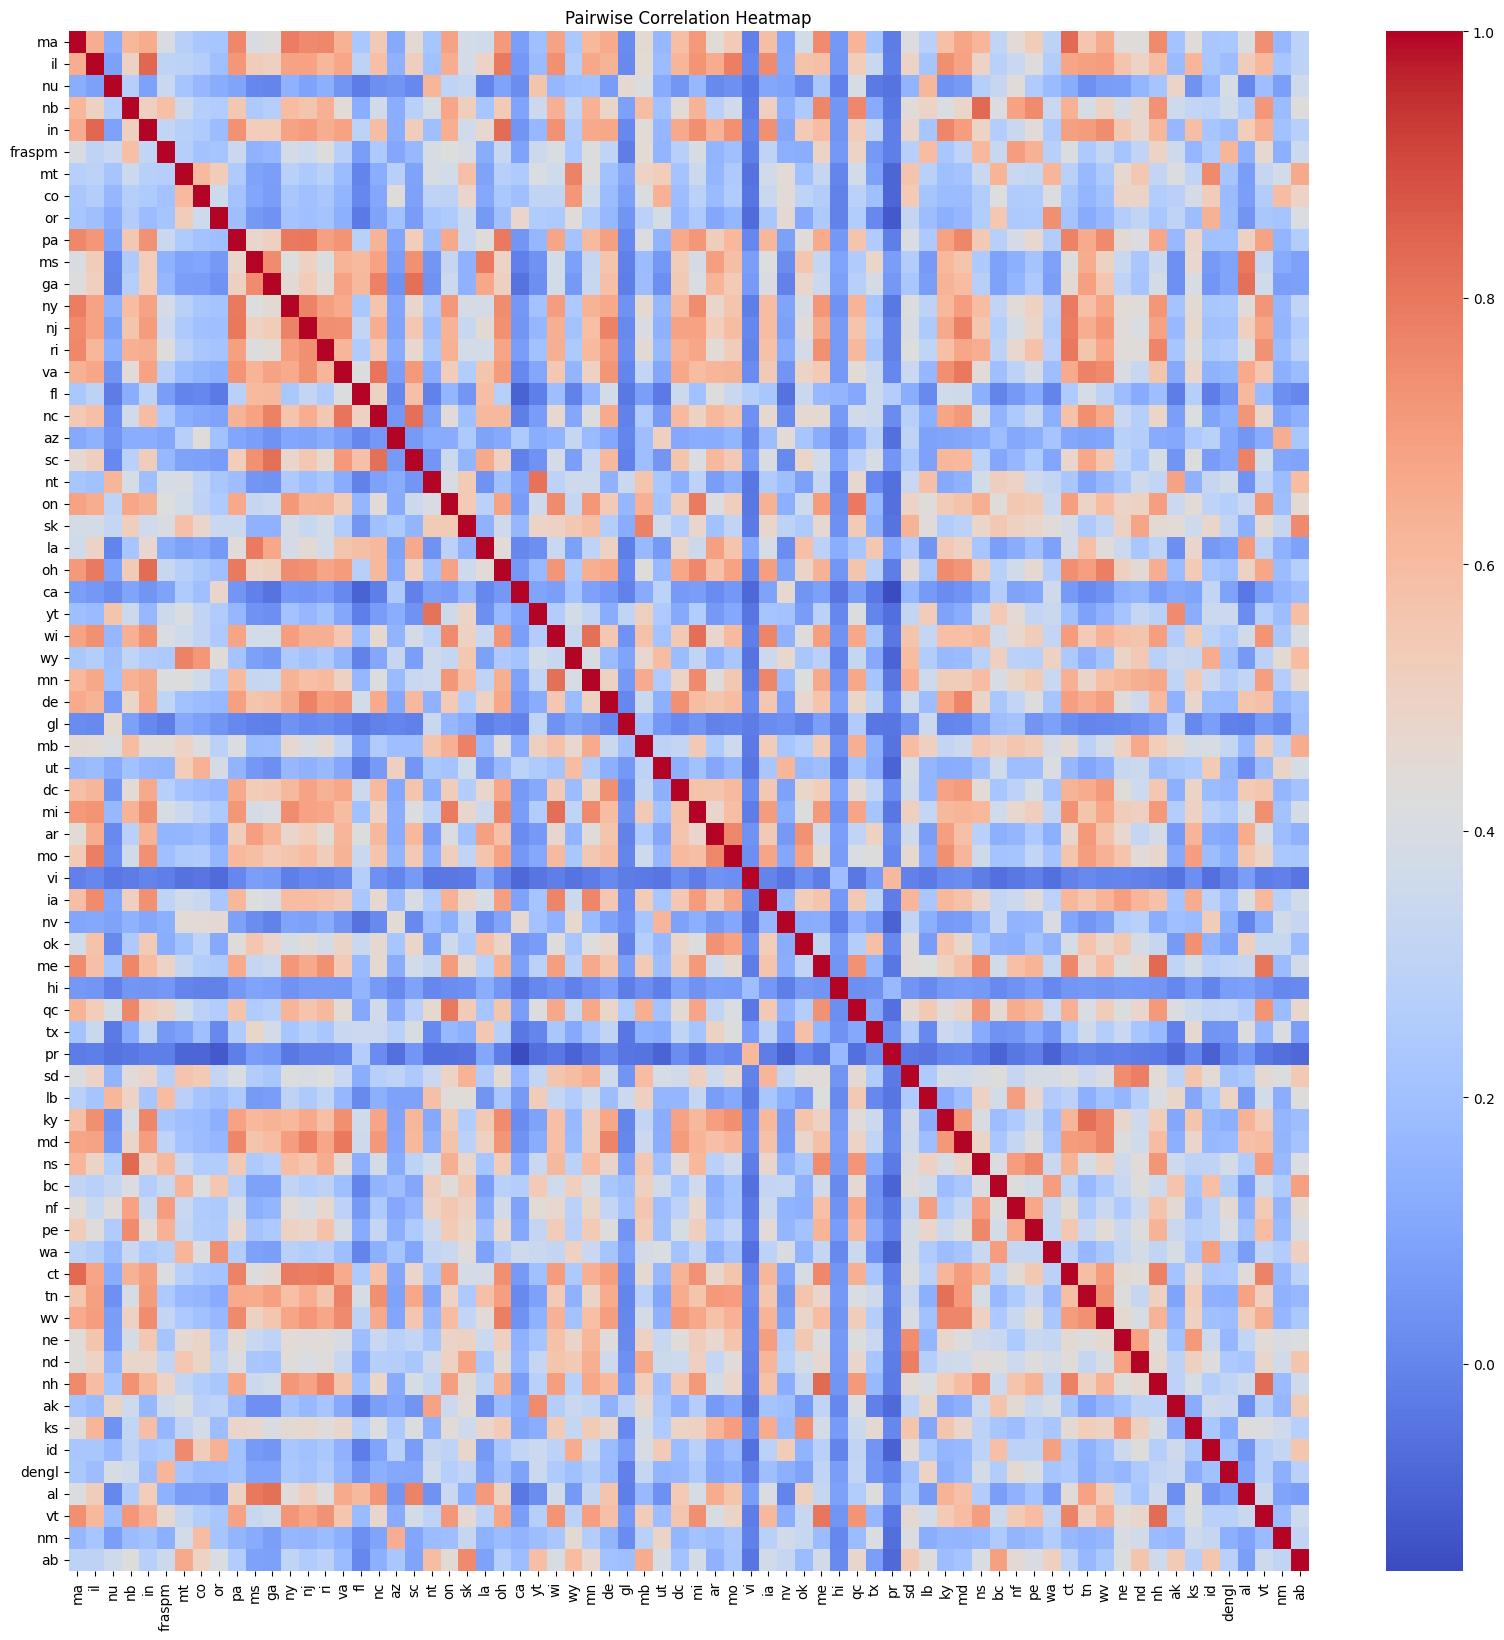

In [70]:
import seaborn as sns

# Set the figure size
fig, ax = plt.subplots(figsize=(20, 20))

# Plot the correlation matrix as a heatmap
sns.heatmap(df.corr(), cmap='coolwarm', ax=ax)
plt.title("Pairwise Correlation Heatmap")
plt.show()

In [117]:
# Create a SparkSession
spark = SparkSession.builder.getOrCreate()

# Convert Pandas DataFrame to PySpark DataFrame
pyspark_df = spark.createDataFrame(df)

/usr/local/lib/python3.9/dist-packages/pyspark/sql/pandas/conversion.py:327: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  (


In [ ]:
# Write Dataframe into HDFS
# Repartition it by "Country" column before storing as parquet files in Hadoop
now = int(time.time())
pyspark_df.write.option("header",True) \
        .mode("overwrite") \
        .parquet("hdfs://hadoop-namenode:9000/plants/{}.parquet".format(now))
print("Plants Dataframe stored in Hadoop.")

In [ ]:
# Read from HDFS to confirm it was successfully stored
pyspark_df = spark.read.parquet("hdfs://hadoop-namenode:9000/plants/{}.parquet".format(now))
print("Plants Dataframe read from Hadoop : ")
pyspark_df.show()

In [118]:
# Select the region columns for clustering
region_columns = pyspark_df.columns[1:]

# Convert the region columns to a vector representation
assembler = VectorAssembler(inputCols=region_columns, outputCol="features")
feature_vector = assembler.transform(pyspark_df)

# K-means

In [120]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import ClusteringEvaluator
import warnings
warnings.filterwarnings("ignore")

# Define the K-means model
kmeans = KMeans(featuresCol="features", predictionCol="prediction")

# Define the parameter grid
kmeans_param_grid = ParamGridBuilder() \
    .addGrid(kmeans.k, range(2, 20+1)) \
    .build()

# Define the evaluator
evaluator = ClusteringEvaluator()

# Define the cross-validator
crossval = CrossValidator(estimator=kmeans,
                          estimatorParamMaps=kmeans_param_grid,
                          evaluator=evaluator,
                          numFolds=5)

# Fit the cross-validator to the data
crossval_model = crossval.fit(feature_vector)

# Get the best K-means model
best_kmeans_model = crossval_model.bestModel

# Get the best K
best_k = best_kmeans_model.getK()

# Evaluate the best K-means model
kmeans_predictions = best_kmeans_model.transform(feature_vector)
kmeans_silhouette = evaluator.evaluate(kmeans_predictions)

# Print the best K and its Silhouette score
print("Best K:", best_k)
print("K-means Silhouette Score:", kmeans_silhouette)

23/06/29 08:45:32 WARN CacheManager: Asked to cache already cached data.
23/06/29 08:45:32 WARN CacheManager: Asked to cache already cached data.
23/06/29 08:45:32 WARN TaskSetManager: Stage 16320 contains a task of very large size (2855 KiB). The maximum recommended task size is 1000 KiB.
23/06/29 08:45:32 WARN TaskSetManager: Stage 16321 contains a task of very large size (2855 KiB). The maximum recommended task size is 1000 KiB.
23/06/29 08:45:32 WARN TaskSetManager: Stage 16322 contains a task of very large size (2855 KiB). The maximum recommended task size is 1000 KiB.
23/06/29 08:45:33 WARN TaskSetManager: Stage 16323 contains a task of very large size (2846 KiB). The maximum recommended task size is 1000 KiB.
23/06/29 08:45:33 WARN TaskSetManager: Stage 16324 contains a task of very large size (2855 KiB). The maximum recommended task size is 1000 KiB.
23/06/29 08:45:33 WARN TaskSetManager: Stage 16325 contains a task of very large size (2846 KiB). The maximum recommended task si

KeyboardInterrupt: 

23/06/29 08:45:37 WARN TaskSetManager: Stage 16386 contains a task of very large size (2846 KiB). The maximum recommended task size is 1000 KiB.
23/06/29 08:45:37 WARN TaskSetManager: Stage 16388 contains a task of very large size (2846 KiB). The maximum recommended task size is 1000 KiB.
23/06/29 08:45:37 WARN TaskSetManager: Stage 16390 contains a task of very large size (2846 KiB). The maximum recommended task size is 1000 KiB.
23/06/29 08:45:37 WARN TaskSetManager: Stage 16391 contains a task of very large size (2855 KiB). The maximum recommended task size is 1000 KiB.
23/06/29 08:45:37 WARN TaskSetManager: Stage 16392 contains a task of very large size (2846 KiB). The maximum recommended task size is 1000 KiB.
23/06/29 08:45:37 WARN TaskSetManager: Stage 16393 contains a task of very large size (2855 KiB). The maximum recommended task size is 1000 KiB.
23/06/29 08:45:37 WARN TaskSetManager: Stage 16394 contains a task of very large size (2846 KiB). The maximum recommended task siz

# Gaussian Mixture

In [43]:
# Define the GMM model
gmm = GaussianMixture(featuresCol="features", predictionCol="prediction")

# Define the parameter grid
param_grid = ParamGridBuilder() \
    .addGrid(gmm.k, [2, 4, 6, 8]) \
    .addGrid(gmm.tol, [0.1, 0.9, 2]) \
    .build()

# Define the evaluator
evaluator = ClusteringEvaluator()

# Define the cross-validator
crossval = CrossValidator(estimator=gmm,
                          estimatorParamMaps=param_grid,
                          evaluator=evaluator,
                          numFolds=5)

# Fit the cross-validator to the data
crossval_model = crossval.fit(feature_vector)

# Get the best GMM model
best_gmm_model = crossval_model.bestModel

# Get the best K from the best model
best_k = best_gmm_model.getK()

# Evaluate the best GMM model
gmm_predictions = best_gmm_model.transform(feature_vector)
gmm_silhouette = evaluator.evaluate(gmm_predictions)

# Print the best K and its Silhouette score
print("Best K:", best_k)
print("GMM Silhouette Score:", gmm_silhouette)

Best K: 2
GMM Silhouette Score: 0.45129699097495196


# Bisecting KMeans

In [45]:

# Define the Bisecting K-means model
bisecting_kmeans = BisectingKMeans(featuresCol="features", predictionCol="prediction")

# Define the parameter grid
param_grid = ParamGridBuilder() \
    .addGrid(bisecting_kmeans.k, [2, 4, 6, 8]) \
    .addGrid(bisecting_kmeans.maxIter, [10, 20, 30]) \
    .build()

# Define the evaluator
evaluator = ClusteringEvaluator()

# Define the cross-validator
crossval = CrossValidator(estimator=bisecting_kmeans,
                          estimatorParamMaps=param_grid,
                          evaluator=evaluator,
                          numFolds=5)

# Fit the cross-validator to the data
crossval_model = crossval.fit(feature_vector)

# Get the best Bisecting K-means model
best_bisecting_kmeans_model = crossval_model.bestModel

# Get the best K and maxIter values
best_k = best_bisecting_kmeans_model.getK()
best_maxIter = best_bisecting_kmeans_model.getMaxIter()

# Evaluate the best Bisecting K-means model
bisecting_kmeans_predictions = best_bisecting_kmeans_model.transform(feature_vector)
bisecting_kmeans_silhouette = evaluator.evaluate(bisecting_kmeans_predictions)

# Print the best K, maxIter, and its Silhouette score
print("Best K:", best_k)
print("Best maxIter:", best_maxIter)
print("Bisecting K-means Silhouette Score:", bisecting_kmeans_silhouette)

Best K: 2
Best maxIter: 20
Bisecting K-means Silhouette Score: 0.7181780188904224


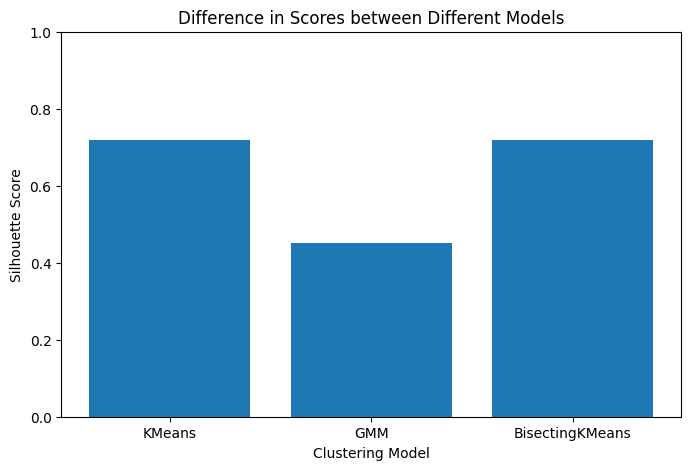

In [75]:
# Calculate the overall score difference between different models
model_names = ['KMeans', 'GMM', 'BisectingKMeans']
model_scores = [kmeans_silhouette, gmm_silhouette, bisecting_kmeans_silhouette]

# Plot the difference in scores between different models
plt.figure(figsize=(8, 5))
plt.ylim(0, 1)
plt.bar(model_names, model_scores)
plt.xlabel('Clustering Model')
plt.ylabel('Silhouette Score')
plt.title('Difference in Scores between Different Models')
plt.show()

In [91]:
kmeans_predictions.count()

23/06/28 19:04:29 WARN TaskSetManager: Stage 12454 contains a task of very large size (2855 KiB). The maximum recommended task size is 1000 KiB.


34781

In [93]:
# Assuming `df` is your PySpark DataFrame
kmeans_rows = kmeans_predictions.head(n=kmeans_predictions.count())
gmm_rows = gmm_predictions.head(n=kmeans_predictions.count())
bisecting_rows = bisecting_kmeans_predictions.head(n=kmeans_predictions.count())

# Print the head rows
dic = {'Plant': [], 'KMeans': [], 'GMM': [],'BisectingKMeans': []}
for row1, row2, row3 in zip(kmeans_rows, gmm_rows, bisecting_rows):
    dic['Plant']          .append(row1.plant)
    dic['KMeans']         .append(row1.prediction)
    dic['GMM']            .append(row2.prediction)
    dic['BisectingKMeans'].append(row3.prediction)

23/06/28 19:11:26 WARN TaskSetManager: Stage 12460 contains a task of very large size (2855 KiB). The maximum recommended task size is 1000 KiB.
23/06/28 19:11:26 WARN TaskSetManager: Stage 12462 contains a task of very large size (2855 KiB). The maximum recommended task size is 1000 KiB.
23/06/28 19:11:27 WARN TaskSetManager: Stage 12463 contains a task of very large size (2846 KiB). The maximum recommended task size is 1000 KiB.
23/06/28 19:11:30 WARN TaskSetManager: Stage 12464 contains a task of very large size (2855 KiB). The maximum recommended task size is 1000 KiB.
23/06/28 19:11:30 WARN TaskSetManager: Stage 12466 contains a task of very large size (2855 KiB). The maximum recommended task size is 1000 KiB.
23/06/28 19:11:33 WARN TaskSetManager: Stage 12467 contains a task of very large size (2846 KiB). The maximum recommended task size is 1000 KiB.
23/06/28 19:11:39 WARN TaskSetManager: Stage 12468 contains a task of very large size (2855 KiB). The maximum recommended task siz

In [94]:
df_predictions = pd.DataFrame(dic)
df_predictions.head()

,Plant,KMeans,GMM,BisectingKMeans
0,abelia,0,1,0
1,abelia x grandiflora,0,1,0
2,abelmoschus,0,0,0
3,abelmoschus esculentus,0,0,0
4,abelmoschus moschatus,0,1,0


In [99]:
print(sum(df_predictions.KMeans != df_predictions.BisectingKMeans))
print(sum(df_predictions.KMeans != df_predictions.GMM))
print(sum(df_predictions.GMM != df_predictions.BisectingKMeans))

11
28227
28238
